In [2]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../data/ctgov/annotations/all_annotations.csv")


# Get data

In [10]:
texts = []
for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]

    with open("../data/ctgov/json/" + file_name + ".json", "r", encoding="utf-8") as f:
        pages = json.load(f)
    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [11]:
df_train = df_annotations[df_annotations.train_val == "train"]

In [12]:
df_val = df_annotations[df_annotations.train_val == "val"]

# Create Naive Bayes model

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

# Train and evaluate the phase extractor

In [17]:
df_train_phase_ground_truth_known = df_train[~df_train.phase.isna()]
model.fit(df_train_phase_ground_truth_known.text, df_train_phase_ground_truth_known.phase)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'all', 'am', 'an', 'and', 'any',
                                             'are', 'aren', "aren't", 'as',
                                             'at', 'au', 'aura', 'aurai',
                                             'auraient', 'aurais', 'aurait',
                                             'auras', 'aurez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [18]:
df_val_phase_ground_truth_known = df_val[~df_val.phase.isna()]


In [19]:
pred_phase = model.predict(df_val_phase_ground_truth_known.text)

In [20]:
acc = accuracy_score(df_val_phase_ground_truth_known.phase, pred_phase)
print (f"Phase accuracy {acc}")

Phase accuracy 0.4531693472090823


''

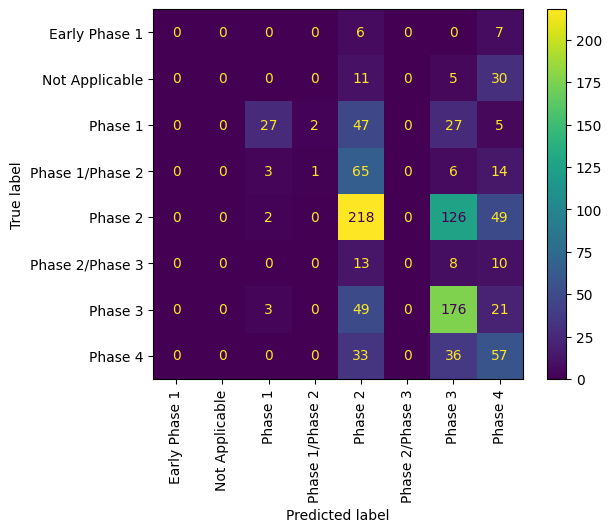

In [21]:
ConfusionMatrixDisplay.from_predictions(df_val_phase_ground_truth_known.phase, pred_phase)
plt.xticks(rotation=90)
;

# Train and evaluate the number of subjects extractor

In [22]:
df_train_num_subjects_ground_truth_known = df_train[~df_train.num_subjects.isna()]

In [23]:
df_val_num_subjects_ground_truth_known = df_val[~df_val.num_subjects.isna()]

In [24]:
model.fit(df_train_num_subjects_ground_truth_known.text, df_train_num_subjects_ground_truth_known.num_subjects)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'all', 'am', 'an', 'and', 'any',
                                             'are', 'aren', "aren't", 'as',
                                             'at', 'au', 'aura', 'aurai',
                                             'auraient', 'aurais', 'aurait',
                                             'auras', 'aurez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [25]:
pred_num_subjects = model.predict(df_val_num_subjects_ground_truth_known.text)

In [27]:
num_subjects_ground_truths = df_val_num_subjects_ground_truth_known.num_subjects.apply(int)
num_subjects_predictions = pred_num_subjects

In [28]:
acc = accuracy_score(num_subjects_ground_truths, num_subjects_predictions)
print (f"Num subjects accuracy {acc}")

Num subjects accuracy 0.06451612903225806


''

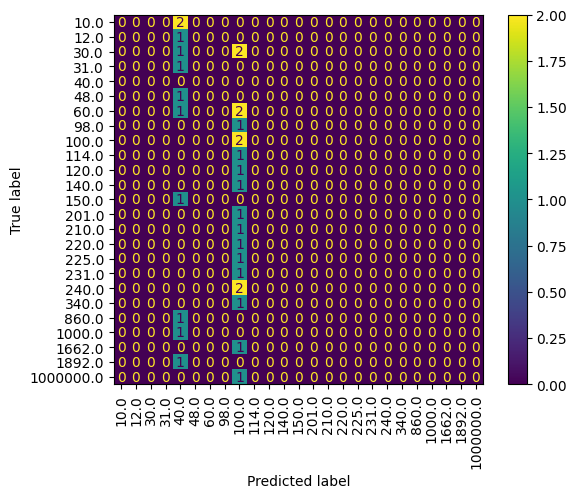

In [29]:
ConfusionMatrixDisplay.from_predictions(num_subjects_ground_truths, num_subjects_predictions)
plt.xticks(rotation=90)
;

In [30]:
mean_absolute_error(num_subjects_ground_truths, num_subjects_predictions)

32475.548387096773

In [31]:
np.sqrt(mean_squared_error(num_subjects_ground_truths, num_subjects_predictions))

179588.02950301056

# Train and evaluate the SAP extractor

In [32]:
model.fit(df_train.text, df_train.has_sap)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'all', 'am', 'an', 'and', 'any',
                                             'are', 'aren', "aren't", 'as',
                                             'at', 'au', 'aura', 'aurai',
                                             'auraient', 'aurais', 'aurait',
                                             'auras', 'aurez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [33]:
sap_ground_truths = df_val.has_sap

In [34]:
sap_predictions = model.predict(df_val.text)

''

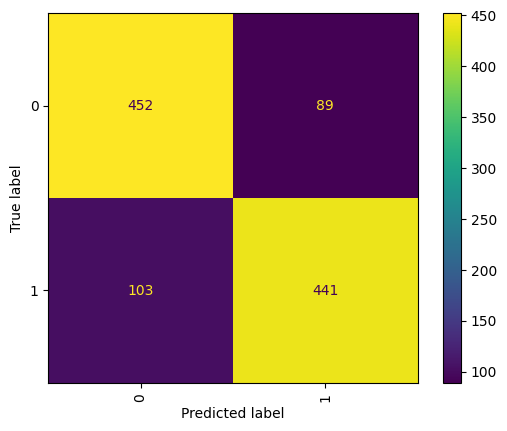

In [35]:
ConfusionMatrixDisplay.from_predictions(sap_ground_truths, sap_predictions)
plt.xticks(rotation=90)
;

In [36]:
acc = accuracy_score(sap_ground_truths, sap_predictions)
print (f"SAP accuracy {acc}")

SAP accuracy 0.8230414746543778


# Train and evaluate the number of arms extractor

In [41]:
df_train_num_arms_ground_truth_known = df_train[~df_train.num_arms.isna()]
len(df_train_num_arms_ground_truth_known)

9273

In [42]:
df_val_num_arms_ground_truth_known = df_val[~df_val.num_arms.isna()]

In [43]:
model.fit(df_train_num_arms_ground_truth_known.text, df_train_num_arms_ground_truth_known.num_arms)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'all', 'am', 'an', 'and', 'any',
                                             'are', 'aren', "aren't", 'as',
                                             'at', 'au', 'aura', 'aurai',
                                             'auraient', 'aurais', 'aurait',
                                             'auras', 'aurez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [44]:
pred_num_arms = model.predict(df_val_num_arms_ground_truth_known.text)

In [45]:
num_arms_ground_truths = df_val_num_arms_ground_truth_known.num_arms

In [49]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.521780303030303


''

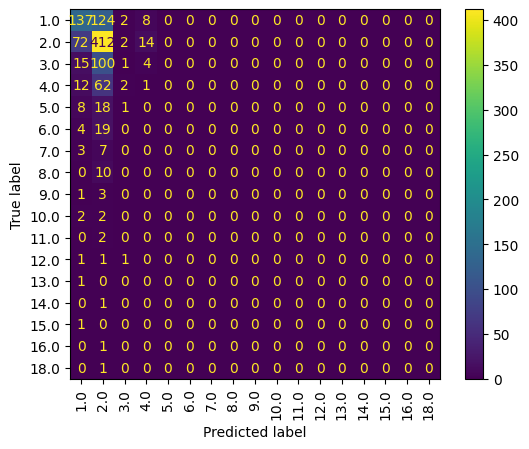

In [50]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;